# Import libraries

In [1]:
%matplotlib inline
import torch as th
import torch.nn.functional as F
import torch.nn as nn 
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split,  RandomizedSearchCV, PredefinedSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_poisson_deviance, d2_tweedie_score, make_scorer, auc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from skorch import NeuralNetRegressor, NeuralNet, callbacks
import utils
import architecture

# Load Models

Get number of units from neural network

In [42]:
all_results_df = pd.read_csv('../results/all_results.csv')
all_results_df 

,params_key,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_module__num_units_2,param_module__num_units_1,params,split0_test_score,mean_test_score,...,test_mean_poisson_deviance,test_weighted_mean_poisson_deviance,test_pde,test_weighted_pde,test_r^2,test_gini,test_min_pred,test_max_pred,test_mean_pred,test_var_pred
0,80_100,327.433788,0.0,0.732649,0.0,80,100,"{'module__num_units_2': 80, 'module__num_units...",0.048840,0.048840,...,0.298633,0.347159,0.065024,0.044932,0.025140,0.257865,0.006985,0.727875,0.054177,0.001558
1,20_100,255.516749,0.0,0.726160,0.0,20,100,"{'module__num_units_2': 20, 'module__num_units...",0.047633,0.047633,...,0.298633,0.347159,0.065024,0.044932,0.025140,0.257865,0.006985,0.727875,0.054177,0.001558
2,20_80,253.142544,0.0,0.724657,0.0,20,80,"{'module__num_units_2': 20, 'module__num_units...",0.047406,0.047406,...,0.298633,0.347159,0.065024,0.044932,0.025140,0.257865,0.006985,0.727875,0.054177,0.001558
3,40_60,270.670018,0.0,0.712800,0.0,40,60,"{'module__num_units_2': 40, 'module__num_units...",0.047012,0.047012,...,0.298633,0.347159,0.065024,0.044932,0.025140,0.257865,0.006985,0.727875,0.054177,0.001558
4,60_20,313.428929,0.0,0.693712,0.0,60,20,"{'module__num_units_2': 60, 'module__num_units...",0.046545,0.046545,...,0.298633,0.347159,0.065024,0.044932,0.025140,0.257865,0.006985,0.727875,0.054177,0.001558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,40_60,25.214639,0.0,0.125267,0.0,40,60,"{'module__num_units_2': 40, 'module__num_units...",0.016257,0.016257,...,0.309322,0.355552,0.031558,0.021841,0.011602,0.192492,0.007818,0.704106,0.047051,0.000669
161,100_20,22.094158,0.0,0.057847,0.0,100,20,"{'module__num_units_2': 100, 'module__num_unit...",0.016151,0.016151,...,0.309322,0.355552,0.031558,0.021841,0.011602,0.192492,0.007818,0.704106,0.047051,0.000669
162,20_20,30.222380,0.0,0.058842,0.0,20,20,"{'module__num_units_2': 20, 'module__num_units...",0.013353,0.013353,...,0.309322,0.355552,0.031558,0.021841,0.011602,0.192492,0.007818,0.704106,0.047051,0.000669
163,20_100,15.634923,0.0,0.063429,0.0,20,100,"{'module__num_units_2': 20, 'module__num_units...",0.011674,0.011674,...,0.309322,0.355552,0.031558,0.021841,0.011602,0.192492,0.007818,0.704106,0.047051,0.000669


Filter to just best hyperparameters

In [43]:
top_results_df = all_results_df.loc[all_results_df['rank_test_score']==1]
top_results_df

,params_key,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_module__num_units_2,param_module__num_units_1,params,split0_test_score,mean_test_score,...,test_mean_poisson_deviance,test_weighted_mean_poisson_deviance,test_pde,test_weighted_pde,test_r^2,test_gini,test_min_pred,test_max_pred,test_mean_pred,test_var_pred
0,80_100,327.433788,0.0,0.732649,0.0,80,100,"{'module__num_units_2': 80, 'module__num_units...",0.048840,0.048840,...,0.298633,0.347159,0.065024,0.044932,0.025140,0.257865,0.006985,0.727875,0.054177,0.001558
15,60_20,20.859230,0.0,0.056848,0.0,60,20,"{'module__num_units_2': 60, 'module__num_units...",0.021654,0.021654,...,0.309629,0.355037,0.030598,0.023259,0.011119,0.192941,0.008313,0.673607,0.053151,0.000848
30,100_20,22.838667,0.0,0.064339,0.0,100,20,"{'module__num_units_2': 100, 'module__num_unit...",0.033253,0.033253,...,0.308499,0.354547,0.034135,0.024607,0.011946,0.201910,0.008613,0.765808,0.059054,0.001001
45,100_100,22.512449,0.0,0.064340,0.0,100,100,"{'module__num_units_2': 100, 'module__num_unit...",0.017621,0.017621,...,0.310913,0.356553,0.026577,0.019087,0.009058,0.174324,0.009608,0.847083,0.057875,0.000844
60,20_100,25.457675,0.0,0.057847,0.0,20,100,"{'module__num_units_2': 20, 'module__num_units...",0.007323,0.007323,...,0.309798,0.356344,0.030068,0.019662,0.009500,0.207026,0.013107,0.783424,0.064390,0.001253
75,20_80,23.061250,0.0,0.057848,0.0,20,80,"{'module__num_units_2': 20, 'module__num_units...",0.024063,0.024063,...,0.309449,0.356575,0.031162,0.019028,0.009799,0.179966,0.007531,0.293779,0.053144,0.000602
90,100_20,25.084596,0.0,0.057847,0.0,100,20,"{'module__num_units_2': 100, 'module__num_unit...",0.027088,0.027088,...,0.308370,0.354320,0.034540,0.025231,0.012103,0.195532,0.009917,0.802715,0.052908,0.000846
105,80_40,19.275867,0.0,0.063404,0.0,80,40,"{'module__num_units_2': 80, 'module__num_units...",0.032790,0.032790,...,0.308458,0.354188,0.034263,0.025594,0.012406,0.202501,0.007627,0.634822,0.049808,0.000715
120,100_20,31.322193,0.0,0.063831,0.0,100,20,"{'module__num_units_2': 100, 'module__num_unit...",0.016287,0.016287,...,0.308900,0.354743,0.032879,0.024069,0.011222,0.194748,0.010278,0.743427,0.054141,0.000746
135,20_100,34.543988,0.0,0.106272,0.0,20,100,"{'module__num_units_2': 20, 'module__num_units...",0.051993,0.051993,...,0.307773,0.353272,0.036407,0.028114,0.013370,0.208191,0.010540,0.536289,0.051086,0.000780


In [44]:
top_results_df[['agent', 'param_module__num_units_1', 'param_module__num_units_2']]

,agent,param_module__num_units_1,param_module__num_units_2
0,-1,100,80
15,0,20,60
30,1,20,100
45,2,100,100
60,3,100,20
75,4,80,20
90,5,20,100
105,6,40,80
120,7,20,100
135,8,100,20


Create dictionary to lookup hyperparameters

In [45]:
top_results_dict = top_results_df[['agent', 'param_module__num_units_1', 'param_module__num_units_2']].set_index('agent').to_dict('index')
top_results_dict

{-1: {'param_module__num_units_1': 100, 'param_module__num_units_2': 80},
 0: {'param_module__num_units_1': 20, 'param_module__num_units_2': 60},
 1: {'param_module__num_units_1': 20, 'param_module__num_units_2': 100},
 2: {'param_module__num_units_1': 100, 'param_module__num_units_2': 100},
 3: {'param_module__num_units_1': 100, 'param_module__num_units_2': 20},
 4: {'param_module__num_units_1': 80, 'param_module__num_units_2': 20},
 5: {'param_module__num_units_1': 20, 'param_module__num_units_2': 100},
 6: {'param_module__num_units_1': 40, 'param_module__num_units_2': 80},
 7: {'param_module__num_units_1': 20, 'param_module__num_units_2': 100},
 8: {'param_module__num_units_1': 100, 'param_module__num_units_2': 20},
 9: {'param_module__num_units_1': 20, 'param_module__num_units_2': 60}}

Use dictionary to access results, for example to lookup `agent=0`:

In [46]:
top_results_dict[0]

{'param_module__num_units_1': 20, 'param_module__num_units_2': 60}

In [47]:
list(top_results_dict[0].items())[0][1]

20

In [48]:
list(top_results_dict[0].items())[1][1]

60

## Create `nn` class

In [49]:
# Define architecture
class MultipleRegression(nn.Module):
    def __init__(self, num_features=39, num_units_1=20, num_units_2=60, activation=nn.Tanh, dropout_rate=0):
        super(MultipleRegression, self).__init__()
        
        self.layer_1 = nn.Linear(num_features, num_units_1)
        self.layer_2 = nn.Linear(num_units_1, num_units_2)
        self.layer_out = nn.Linear(num_units_2, 1)
        self.dropout = nn.Dropout(dropout_rate)
        
        self.act = activation()

        th.nn.init.xavier_uniform_(self.layer_1.weight)
        th.nn.init.zeros_(self.layer_1.bias)
        th.nn.init.xavier_uniform_(self.layer_2.weight)
        th.nn.init.zeros_(self.layer_2.bias)
        th.nn.init.xavier_uniform_(self.layer_out.weight)
        th.nn.init.zeros_(self.layer_out.bias)
    
    def forward(self, inputs):
        x = self.dropout(self.act(self.layer_1(inputs)))
        x = self.dropout(self.act(self.layer_2(x)))
        x = th.exp(self.layer_out(x))

        return (x)

    def predict(self, test_inputs):
        x = self.act(self.layer_1(test_inputs))
        x = self.act(self.layer_2(x))
        x = th.exp(self.layer_out(x))

        return (x)

## Create load model function

In [50]:
def load_model(agent=-1, num_features=39, num_units_1=20, num_units_2=60):

    num_units_1 = list(top_results_dict[agent].items())[0][1]
    num_units_2 = list(top_results_dict[agent].items())[1][1]

    loaded_agent_model = NeuralNetRegressor(MultipleRegression(num_features, num_units_1, num_units_2).double())
    loaded_agent_model.initialize()  # This is important!
    loaded_agent_model.load_params(f_params=f'../ag_'+str(agent)+'/agent_'+str(agent)+'_model.pkl', 
                                       f_optimizer=f'../ag_'+str(agent)+'/agent_'+str(agent)+'_opt.pkl', 
                                       f_history=f'../ag_'+str(agent)+'/agent_'+str(agent)+'_history.json')
    
    return loaded_agent_model

## Loop through

In [51]:
NUM_AGENTS = 10

In [52]:
agent_model_dictionary = {}
for agents in range(NUM_AGENTS):
    agent_model_dictionary["loaded_agent_{0}_model".format(agents)] = eval('load_model(agent='+str(agents)+')')

## Load Federated Model

In [53]:
fl_model = architecture.MultipleRegression(39)

In [54]:
FL_PATH = '../ag_-1/fl_model.pt'

In [55]:
fl_model.load_state_dict(th.load(FL_PATH))
fl_model.eval()

MultipleRegression(
  (layer_1): Linear(in_features=39, out_features=20, bias=True)
  (layer_2): Linear(in_features=20, out_features=100, bias=True)
  (layer_out): Linear(in_features=100, out_features=1, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (act): Tanh()
)

Again can lookup each agent's model

In [56]:
agent_model_dictionary['loaded_agent_0_model']

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=MultipleRegression(
    (layer_1): Linear(in_features=39, out_features=20, bias=True)
    (layer_2): Linear(in_features=20, out_features=60, bias=True)
    (layer_out): Linear(in_features=60, out_features=1, bias=True)
    (dropout): Dropout(p=0, inplace=False)
    (act): Tanh()
  ),
)

## Load global model

In [57]:
loaded_agent_global_model = load_model(agent=-1)

# Load Test Data and Functions

In [58]:
def frequency_conversion(FACTOR, df, freq_dictionary):
      for key in freq_dictionary:
            df[freq_dictionary[key]]=df[key]/df['Exposure']

      df.insert(1,FACTOR+'_binned_midpoint',[round((a.left + a.right)/2,0) for a in df[FACTOR+'_binned']])

In [59]:
def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

In [60]:
def create_test_data(): 
    (X_train, X_val, X_test, y_train, y_val, y_test, X_column_names, scaler) = utils.upload_dataset()
    
    MY_DATA_PATH = '../data'
    
    X_test_sc = pd.read_csv(MY_DATA_PATH + '/X_test.csv')
    y_te = pd.read_csv(MY_DATA_PATH + '/y_test.csv')
    X_column_names = X_test_sc.columns.tolist()

    test_complete_data=np.column_stack((X_test_sc, y_te))

    X_column_names.append('ClaimNb')

    #Convert dataset of test data, actuals, and prediction back into dataframe

    df_test=pd.DataFrame(data=test_complete_data,    # values
                    columns=X_column_names)  # 1st row as the column names
    
    # Un one-hot encode Region and VehBrand
    df_test = undummify(df_test)
    df_test['VehBrand_number'] = df_test['VehBrand'].str[1:].astype(int)
    df_test['Region_number'] = df_test['Region'].str[1:].astype(int)


    df_test[['Area', 'VehPower', 'VehAge','DrivAge','BonusMalus','Density']]=scaler.inverse_transform(df_test[['Area', 'VehPower', 'VehAge','DrivAge','BonusMalus','Density']] )
    
    #Bin factors
    factor_list = ['Area', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'VehGas', 'Density', 'VehBrand_number', 'Region_number']
    
    # If fewer levels than MAX_BINSIZE no effective binning happens via the min() function, not used currently
    MAX_BINSIZE = 20

    # Automatic binning not used, could use qcut as well 
    for i in factor_list:
        df_test[i+'_binned'] = pd.cut(df_test[i], bins=min(len(df_test[i].unique()), MAX_BINSIZE), duplicates='drop')
        #df_test[i+'_binned'] = pd.cut(df_test[i], bins=np.linspace(0, max(df_test[i]), min(21, len(df_test[i].unique()))), duplicates='drop')
    
    # Custom binning used instead to define more sensible bins
    df_test['Area'+'_binned'] = pd.cut(df_test['Area'], bins=np.linspace(0, 7, 8), duplicates='drop')
    df_test['VehPower'+'_binned'] = pd.cut(df_test['VehPower'], bins=np.linspace(0, 15, 16), duplicates='drop')
    df_test['VehAge'+'_binned'] = pd.cut(df_test['VehAge'], bins=np.linspace(0, 20, 21), duplicates='drop')
    df_test['DrivAge'+'_binned'] = pd.cut(df_test['DrivAge'], bins=np.linspace(0, 100, 21), duplicates='drop')
    df_test['BonusMalus'+'_binned'] = pd.qcut(df_test['BonusMalus'], q=15, duplicates='drop') # note usin qcut here
    df_test['Density'+'_binned'] = pd.cut(df_test['Density'], bins=np.linspace(0, 11, 12), duplicates='drop')
    df_test['VehBrand_number'+'_binned'] = pd.cut(df_test['VehBrand_number'], bins=np.linspace(0, 15, 16), duplicates='drop')
    df_test['Region_number'+'_binned'] = pd.cut(df_test['Region_number'], bins=np.linspace(0, 100, 21), duplicates='drop')
    df_test['VehGas'+'_binned'] = pd.cut(df_test['VehGas'], bins=np.linspace(0, 2, 3), duplicates='drop')
    
    return X_test, y_test, df_test

In [61]:
X_test, y_test, df_test = create_test_data()

In [62]:
def create_df_test_pred(df_test, X_test, global_model, NUM_AGENTS):
    
    # Global Model Predictions
    y_pred = global_model.predict(X_test.astype(np.float64))
    df_test['ClaimNb_pred']=pd.Series(y_pred.flatten())

    # FL Model Predictions
    y_fl_pred = fl_model.predict(th.tensor(X_test).float())
    df_test['ClaimNb_fl_pred']=pd.Series(y_fl_pred.flatten().detach().numpy())

    # Local Model Predictions

    agent_prediction_dictionary = {}

    for agents in range(NUM_AGENTS):
        agent_prediction_dictionary["y_agent_{0}_pred".format(agents)] = agent_model_dictionary['loaded_agent_'+str(agents)+'_model'].predict(X_test.astype(np.float64))
        df_test['ClaimNb_agent_'+str(agents)+'_pred']=pd.Series(agent_prediction_dictionary['y_agent_'+str(agents)+'_pred'].flatten())

    return df_test

In [63]:
df_test_pred = create_df_test_pred(df_test, X_test, loaded_agent_global_model, NUM_AGENTS)
df_test_pred

,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehGas,Density,VehBrand,Region,...,ClaimNb_agent_0_pred,ClaimNb_agent_1_pred,ClaimNb_agent_2_pred,ClaimNb_agent_3_pred,ClaimNb_agent_4_pred,ClaimNb_agent_5_pred,ClaimNb_agent_6_pred,ClaimNb_agent_7_pred,ClaimNb_agent_8_pred,ClaimNb_agent_9_pred
0,1.000000,1.0,4.0,11.0,45.0,50.0,1.0,2.197225,B3,R24,...,0.069021,0.067195,0.079159,0.061066,0.065029,0.065414,0.061904,0.061469,0.050479,0.051174
1,0.700000,3.0,7.0,3.0,26.0,68.0,1.0,5.774552,B6,R31,...,0.083632,0.055512,0.075651,0.059140,0.059713,0.050147,0.059717,0.073346,0.046988,0.058851
2,0.460000,4.0,9.0,15.0,21.0,95.0,1.0,6.960348,B3,R24,...,0.050302,0.065885,0.061444,0.069020,0.068540,0.065514,0.061163,0.052093,0.052680,0.044008
3,0.450000,5.0,4.0,0.0,69.0,50.0,1.0,8.325548,B12,R52,...,0.047022,0.068829,0.049699,0.049071,0.073418,0.055224,0.052458,0.068097,0.055526,0.050553
4,0.490000,6.0,9.0,1.0,57.0,50.0,1.0,10.060320,B2,R21,...,0.061646,0.063436,0.072026,0.081006,0.077218,0.056542,0.056577,0.065504,0.067241,0.062023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135598,0.070000,3.0,9.0,0.0,53.0,50.0,1.0,5.953243,B12,R82,...,0.047102,0.050806,0.048024,0.049895,0.047150,0.046962,0.044350,0.041926,0.035323,0.040946
135599,0.110000,3.0,9.0,16.0,37.0,50.0,1.0,6.003887,B14,R24,...,0.016601,0.026269,0.010991,0.017794,0.010732,0.019821,0.011677,0.013778,0.014021,0.011710
135600,0.008219,4.0,7.0,0.0,56.0,50.0,1.0,6.628041,B12,R26,...,0.028220,0.045800,0.035880,0.032227,0.046353,0.033556,0.034607,0.039506,0.038898,0.030406
135601,0.280000,5.0,5.0,17.0,50.0,90.0,1.0,9.138522,B5,R82,...,0.057069,0.068147,0.048175,0.079840,0.050976,0.058041,0.050998,0.047659,0.049428,0.041498


In [64]:
df_test[['ClaimNb_fl_pred', 'ClaimNb_agent_0_pred', 'ClaimNb_pred']]

,ClaimNb_fl_pred,ClaimNb_agent_0_pred,ClaimNb_pred
0,0.041936,0.069021,0.041515
1,0.050508,0.083632,0.064965
2,0.069785,0.050302,0.071895
3,0.096170,0.047022,0.187797
4,0.045629,0.061646,0.060442
...,...,...,...
135598,0.084880,0.047102,0.123322
135599,0.014415,0.016601,0.017301
135600,0.094951,0.028220,0.102854
135601,0.067886,0.057069,0.072862


In [65]:
min( df_test['ClaimNb_fl_pred'])

0.006352204829454422

In [66]:
def create_df_sum(df_test_pred, factor, NUM_AGENTS):

    sum_list = ['Exposure',  'ClaimNb', 'ClaimNb_pred', 'ClaimNb_fl_pred']
    sum_dictionary = {'ClaimNb':'Actual freq', 'ClaimNb_pred':'Freq pred global model', 'ClaimNb_fl_pred':'Freq pred FL model'}

    for agents in range(NUM_AGENTS):
        sum_list.append('ClaimNb_agent_'+str(agents)+'_pred')
        sum_dictionary['ClaimNb_agent_'+str(agents)+'_pred']='Freq pred agent '+str(agents)+' model'

    df_sum=df_test_pred.groupby([factor+'_binned'])[sum_list].sum().reset_index()

    frequency_conversion(factor, df_sum, sum_dictionary)

    # Remove rows with 0 exposure
    df_sum = df_sum.loc[df_sum['Exposure']!=0]
    df_sum = df_sum.reset_index(drop=True)

    return df_sum

In [67]:
def one_way_graph_comparison(factor, NUM_AGENTS):

        df_sum = create_df_sum(df_test_pred, factor, NUM_AGENTS)
        
        fig, ax = plt.subplots(figsize=(12, 8))

        plt.plot(df_sum['Actual freq'],  
                label='Actual freq',
                marker='s',
                markersize=10,
                )
        
        for agents in range(NUM_AGENTS):
                plt.plot(df_sum['Freq pred agent '+str(agents)+' model'],  
                label='Freq pred agent '+str(agents)+' model',
                marker='o',
                markersize=5,
                linestyle=(0, (1, 10)),
                #linestyle='dotted',
                )


        plt.plot(df_sum['Freq pred FL model'],  
                label='Freq pred FL model',
                marker='o',
                markersize=10,
                #linestyle='dotted',
                )
        
        plt.plot(df_sum['Freq pred global model'],  
                label='Freq pred global model',
                marker='s',
                markersize=10,
                #linestyle='dotted',
                )

        plt.legend(bbox_to_anchor=(1.08, 1), loc='upper left', borderaxespad=0)

        plt.xlabel(factor+'_binned')
        plt.xticks(rotation = 75)
        plt.ylabel('Frequency')
        plt.grid()


        # Get second axis
        ax2 = ax.twinx()

        plt.bar(df_sum[factor+'_binned'].astype(str), 
                df_sum['Exposure'], 
                label='Exposure', 
                color='y',
                alpha=0.35
                )

        plt.ylabel('Exposure', color='y')
        plt.xticks(rotation = 90)

        vals = ax2.get_yticks()
        ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])

        plt.legend(bbox_to_anchor=(1.08, 0), loc='upper left', borderaxespad=0)

        plt.show()

# Graphs

C:\Users\dylan\AppData\Local\Temp\ipykernel_223792\3843640938.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


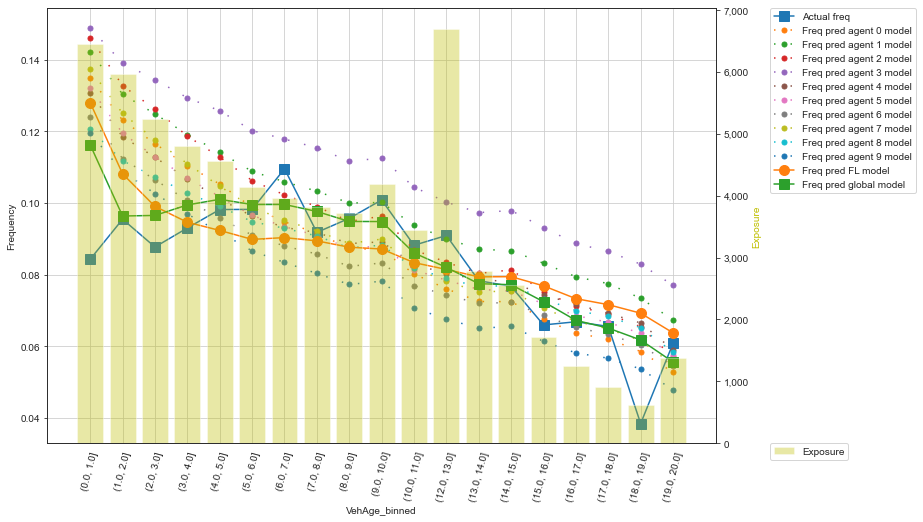

In [68]:
one_way_graph_comparison('VehAge', NUM_AGENTS)

C:\Users\dylan\AppData\Local\Temp\ipykernel_223792\3843640938.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


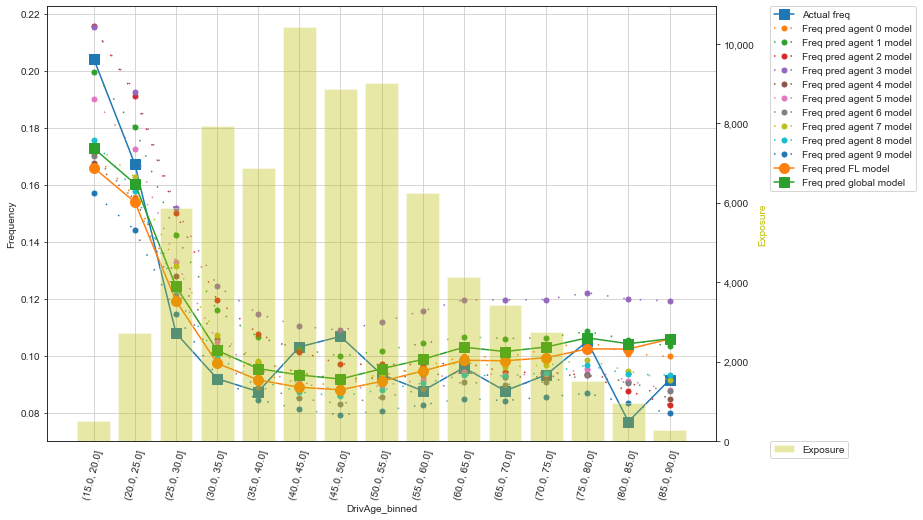

In [69]:
one_way_graph_comparison('DrivAge', NUM_AGENTS)

C:\Users\dylan\AppData\Local\Temp\ipykernel_223792\3843640938.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


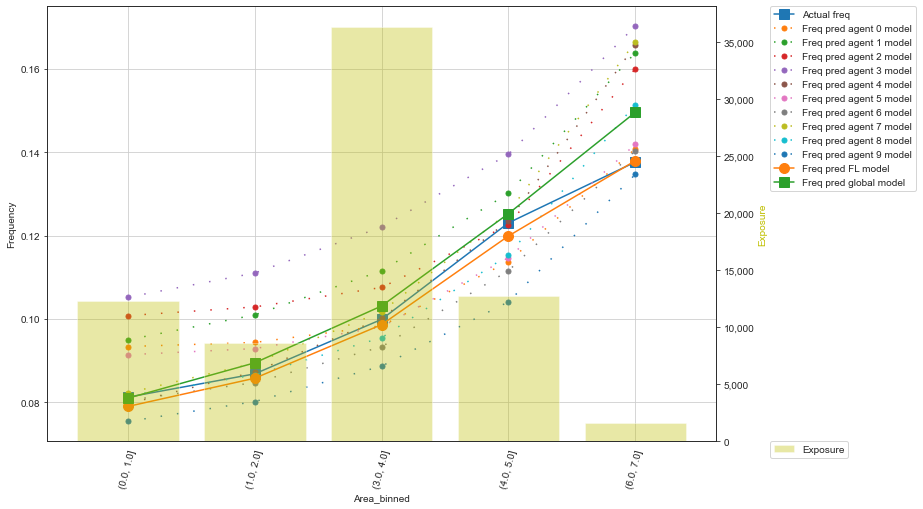

C:\Users\dylan\AppData\Local\Temp\ipykernel_223792\3843640938.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


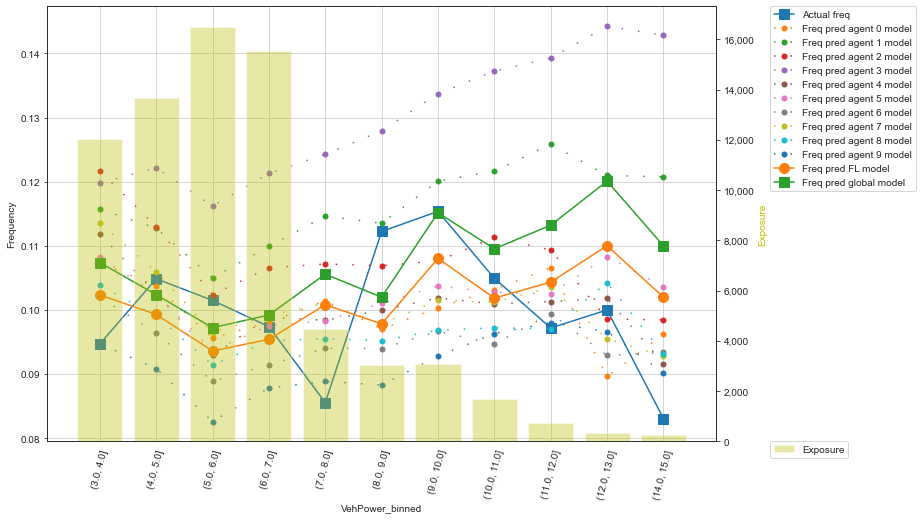

C:\Users\dylan\AppData\Local\Temp\ipykernel_223792\3843640938.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


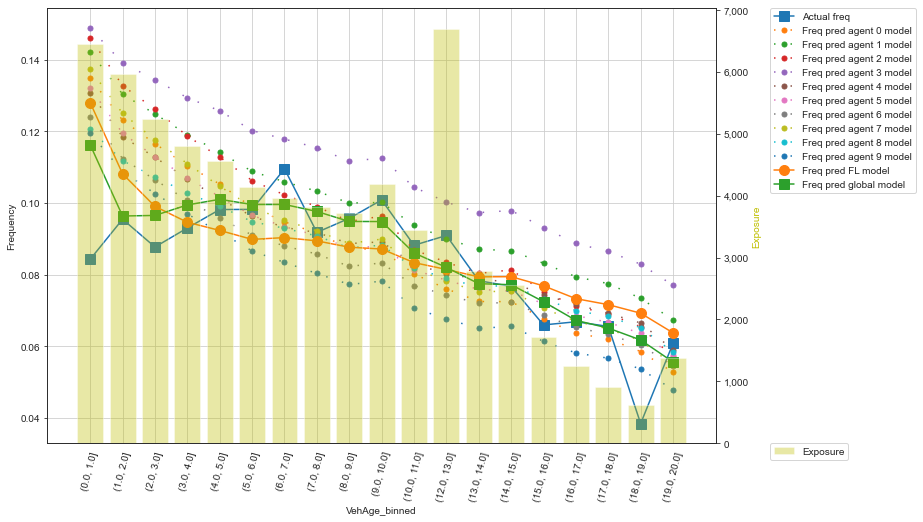

C:\Users\dylan\AppData\Local\Temp\ipykernel_223792\3843640938.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


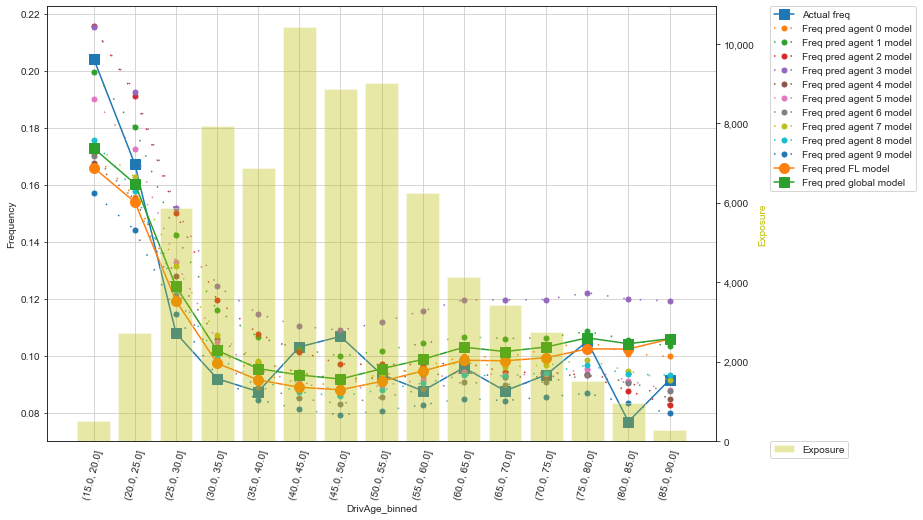

C:\Users\dylan\AppData\Local\Temp\ipykernel_223792\3843640938.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


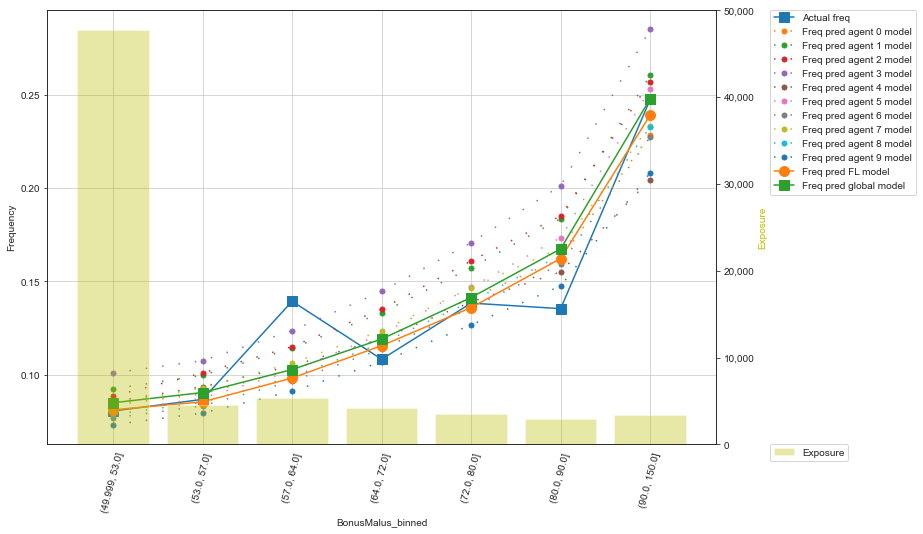

C:\Users\dylan\AppData\Local\Temp\ipykernel_223792\3843640938.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


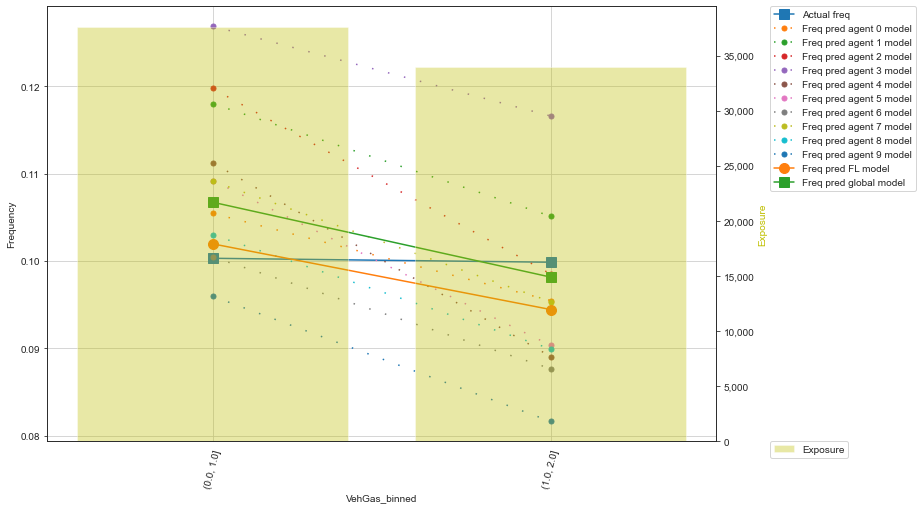

C:\Users\dylan\AppData\Local\Temp\ipykernel_223792\3843640938.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


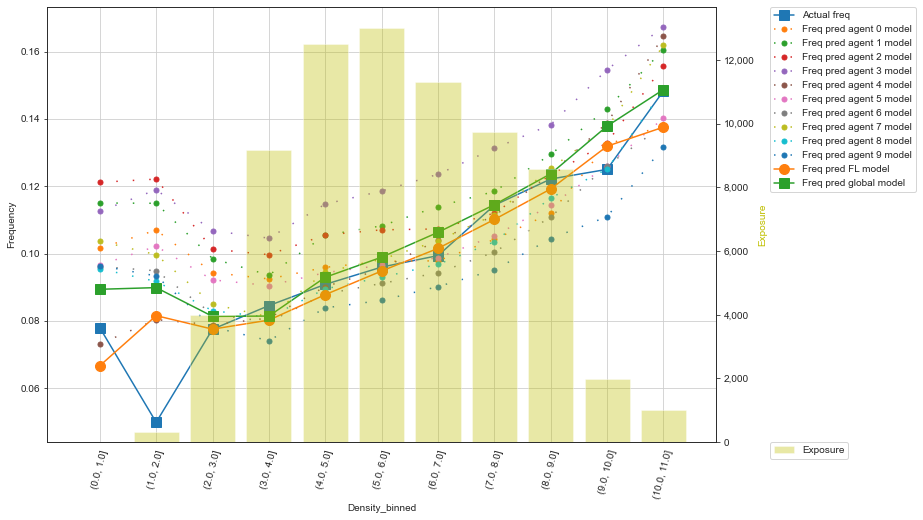

C:\Users\dylan\AppData\Local\Temp\ipykernel_223792\3843640938.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


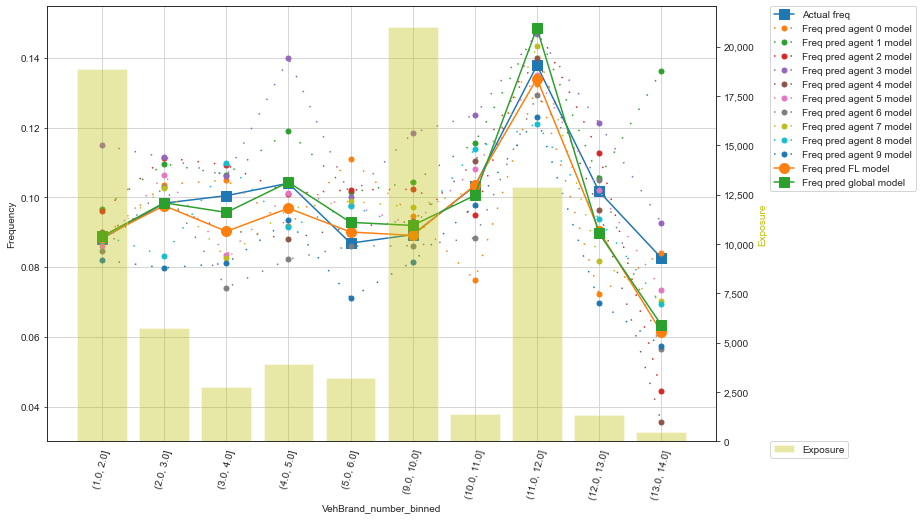

C:\Users\dylan\AppData\Local\Temp\ipykernel_223792\3843640938.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


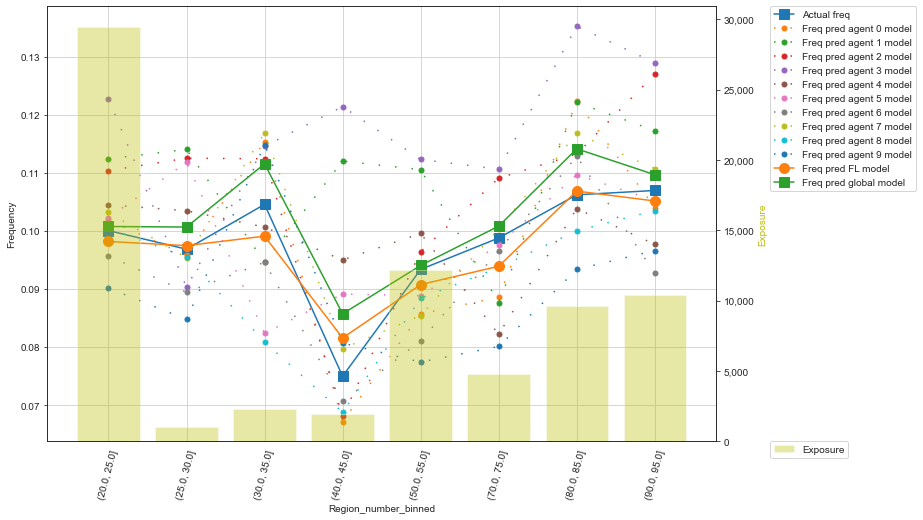

In [70]:
for i in ['Area', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'VehGas', 'Density', 'VehBrand_number', 'Region_number']:
    one_way_graph_comparison(i, NUM_AGENTS)

## Gini

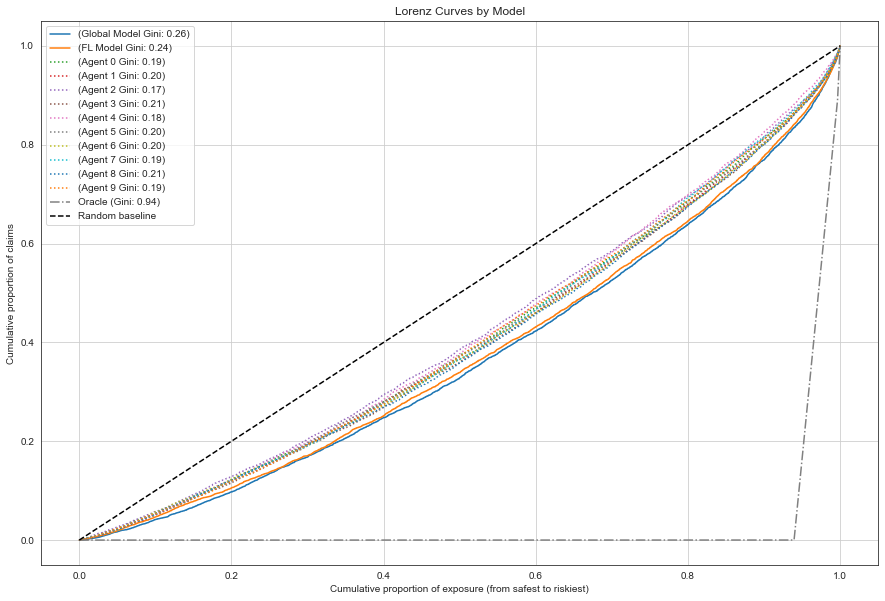

In [71]:
fig, ax = plt.subplots(figsize=(15, 10))

cum_exposure, cum_claims = utils.lorenz_curve(
    df_test_pred['ClaimNb'], df_test_pred['ClaimNb_pred'], df_test_pred["Exposure"]
)
gini = 1 - 2 * auc(cum_exposure, cum_claims)
label = "(Global Model Gini: {:.2f})".format(gini)
ax.plot(cum_exposure, cum_claims, linestyle="-", label=label)

cum_exposure, cum_claims = utils.lorenz_curve(
    df_test_pred['ClaimNb'], df_test_pred['ClaimNb_fl_pred'], df_test_pred["Exposure"]
)
gini = 1 - 2 * auc(cum_exposure, cum_claims)
label = "(FL Model Gini: {:.2f})".format(gini)
ax.plot(cum_exposure, cum_claims, linestyle="-", label=label)

for agents in range(NUM_AGENTS):
    cum_exposure, cum_claims = utils.lorenz_curve(
        df_test_pred['ClaimNb'], df_test_pred['ClaimNb_agent_'+str(agents)+'_pred'], df_test_pred["Exposure"]
    )
    gini = 1 - 2 * auc(cum_exposure, cum_claims)
    label = '(Agent {} Gini: {:.2f})'.format(agents, gini)
    plt.plot(cum_exposure, cum_claims, linestyle="dotted", label=label)

# Oracle model: y_pred == y_test
cum_exposure, cum_claims = utils.lorenz_curve(
    df_test_pred['ClaimNb'], df_test_pred['ClaimNb'], df_test_pred["Exposure"]
)
gini = 1 - 2 * auc(cum_exposure, cum_claims)
label = "Oracle (Gini: {:.2f})".format(gini)
ax.plot(cum_exposure, cum_claims, linestyle="-.", color="gray", label=label)

# Random Baseline
ax.plot([0, 1], [0, 1], linestyle="--", color="black", label="Random baseline")
ax.set(
    title="Lorenz Curves by Model",
    xlabel="Cumulative proportion of exposure (from safest to riskiest)",
    ylabel="Cumulative proportion of claims",
)

plt.grid()
ax.legend(loc="upper left")

#plt.savefig(f'../ag_{ag}/' + 'lift_chart')

# Metric

In [72]:
y_fl_tensor_pred = fl_model.predict(th.tensor(X_test).float())

In [73]:
y_fl_pred=pd.Series(y_fl_tensor_pred.flatten().detach().numpy())

In [74]:
y_fl_pred= df_test['ClaimNb_fl_pred']

In [75]:
y_fl_pred

0         0.041936
1         0.050508
2         0.069785
3         0.096170
4         0.045629
            ...   
135598    0.084880
135599    0.014415
135600    0.094951
135601    0.067886
135602    0.023974
Name: ClaimNb_fl_pred, Length: 135603, dtype: float32

In [76]:
y_test

array([0., 0., 0., ..., 0., 0., 0.])

In [77]:
fl_weighted_pde = d2_tweedie_score(y_test, y_fl_pred, sample_weight=X_test[:, 0], power=1)
fl_weighted_pde 

0.03931576212407217

In [78]:
weighted_pde_df = top_results_df[['agent', 'test_weighted_pde']]
weighted_pde_df

,agent,test_weighted_pde
0,-1,0.044932
15,0,0.023259
30,1,0.024607
45,2,0.019087
60,3,0.019662
75,4,0.019028
90,5,0.025231
105,6,0.025594
120,7,0.024069
135,8,0.028114


In [79]:
weighted_pde_df.loc[151] = [-2, d2_tweedie_score(y_test, y_fl_pred, sample_weight=X_test[:, 0], power=1)]
weighted_pde_df

C:\Users\dylan\AppData\Local\Temp\ipykernel_223792\1077199988.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weighted_pde_df.loc[151] = [-2, d2_tweedie_score(y_test, y_fl_pred, sample_weight=X_test[:, 0], power=1)]


,agent,test_weighted_pde
0,-1.0,0.044932
15,0.0,0.023259
30,1.0,0.024607
45,2.0,0.019087
60,3.0,0.019662
75,4.0,0.019028
90,5.0,0.025231
105,6.0,0.025594
120,7.0,0.024069
135,8.0,0.028114


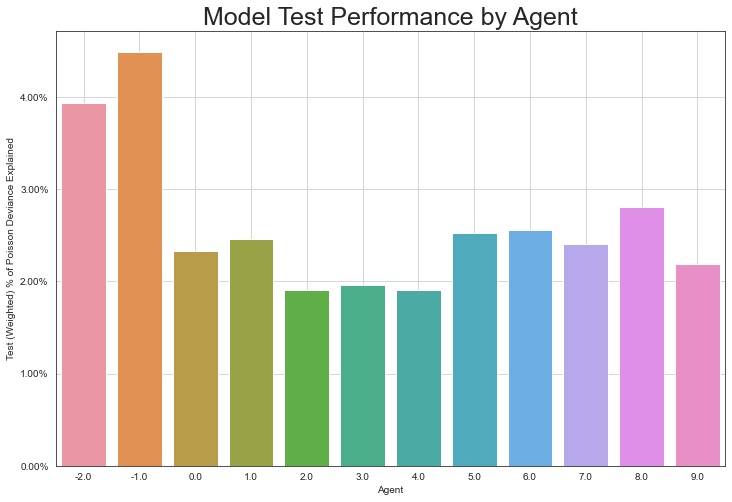

In [80]:
fig, ax = plt.subplots(figsize=(12,8))

sns.set_style('white')

ax=sns.barplot(x='agent', y='test_weighted_pde',
               data=weighted_pde_df[['agent', 'test_weighted_pde']])
plt.title('Model Test Performance by Agent', fontsize=25)

plt.xticks(fontsize=10)
plt.ylabel('Test (Weighted) % of Poisson Deviance Explained', fontsize=10)
plt.xlabel('Agent', fontsize=10)
plt.yticks(fontsize=10)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.grid(True)
plt.show()

# End

In [158]:
NUM_AGENTS=10

In [153]:
import csv
from fpdf import FPDF

In [154]:
import run_config
import os
import calendar
from datetime import datetime
import torch
from torch import nn, optim
from sklearn.metrics import auc
import json
import utils

# Run config:
NUM_AGENTS = utils.run_config.dataset_config["num_agents"]
NUM_ROUNDS = utils.run_config.server_config["num_rounds"]
NUM_FEATURES = run_config.model_architecture["num_features"]
EPOCHS = run_config.model_architecture["epochs"]
EPOCHS_LOCAL_GLOBAL = run_config.EPOCHS_LOCAL_GLOBAL

In [155]:
MARGIN = 10 # Margin
pw = 210 - 2*MARGIN # Page width: Width of A4 is 210mm
ch = 10 # Cell height


In [156]:
# Custom class to overwrite the header and footer methods
class PDF(FPDF):
    def __init__(self):
        super().__init__()
        self.WIDTH = 150
        self.HEIGHT = 350
    
    def page_body(self, images):
        # Determine how many plots there are per page and set positions
        # and margins accordingly
        if len(images) == 3:
            self.image(images[0], 15, 25, self.WIDTH - 30)
            self.image(images[1], 15, 90, self.WIDTH - 30)
            self.image(images[2], 15, 160, self.WIDTH - 30)
        elif len(images) == 2:
            self.image(images[0], 15, 25, self.WIDTH - 30)
            self.image(images[1], 15, self.WIDTH / 2 + 5, self.WIDTH - 30)
        else:
            self.image(images[0], 15, 25, self.WIDTH - 30)
            
    def print_page(self, images):
        # Generates the report
        self.add_page()
        self.page_body(images)

pdf = PDF()
pdf.add_page()
pdf.set_font('Arial', '', 12)

text = "Run Results: num_agents: " + str(NUM_AGENTS) + "; num_rounds: " + str(NUM_ROUNDS) + "; epochs: " + str(EPOCHS) + "; epochs local and global: " + str(EPOCHS_LOCAL_GLOBAL)
pdf.cell(w=0, h=ch, txt=text, border=1, ln=1)

In [159]:
def read_csv(filename):
    loss_stats_dict = dict()
    with open(filename) as f:
        file_data=csv.reader(f)
        headers=next(file_data)
        round = 0
        for i in file_data:
            loss_stats_dict[round] = dict(zip(headers,i))
            round +=1
    return loss_stats_dict

loss_stats = dict()
for ag_id in range(-1, NUM_AGENTS):
    if ag_id == -1:
        MY_DATA_PATH = '../ag_global'
    else:    
        MY_DATA_PATH = '../ag_' + str(ag_id)
    
    loss_stats[ag_id] = read_csv(MY_DATA_PATH + '/los_stats.csv')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ag_id  0 rnd_no  1
ag_id  0 rnd_no  3
ag_id  0 rnd_no  5
ag_id  0 rnd_no  7
ag_id  0 rnd_no  9
ag_id  0 rnd_no  11
ag_id  0 rnd_no  13
ag_id  0 rnd_no  15
ag_id  0 rnd_no  17
ag_id  0 rnd_no  19
ag_id  0 rnd_no  21
ag_id  0 rnd_no  23
ag_id  0 rnd_no  25
ag_id  0 rnd_no  27
ag_id  0 rnd_no  29
ag_id  0 rnd_no  31
ag_id  0 rnd_no  33
ag_id  0 rnd_no  35
ag_id  0 rnd_no  37
ag_id  0 rnd_no  39
ag_id  0 rnd_no  41
ag_id  0 rnd_no  43
ag_id  0 rnd_no  45
ag_id  0 rnd_no  47
ag_id  0 rnd_no  49
ag_id  0 rnd_no  51
ag_id  0 rnd_no  53
ag_id  0 rnd_no  55
ag_id  0 rnd_no  57
ag_id  0 rnd_no  59
ag_id  0 rnd_no  61
ag_id  0 rnd_no  63
ag_id  0 rnd_no  65
ag_id  0 rnd_no  67
ag_id  0 rnd_no  69
ag_id  0 rnd_no  71
ag_id  0 rnd_no  73
ag_id  0 rnd_no  75
ag_id  0 rnd_no  77
ag_id  0 rnd_no  79
ag_id  0 rnd_no  81
ag_id  0 rnd_no  83
ag_id  0 rnd_no  85
ag_id  0 rnd_no  87
ag_id  0 rnd_no  89
ag_id  0 rnd_no  91
ag_id  0 rnd_no  93
ag_id  0 rnd_no  95
ag_id  0 rnd_no  97
ag_id  0 rnd_no  99
ag_id

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

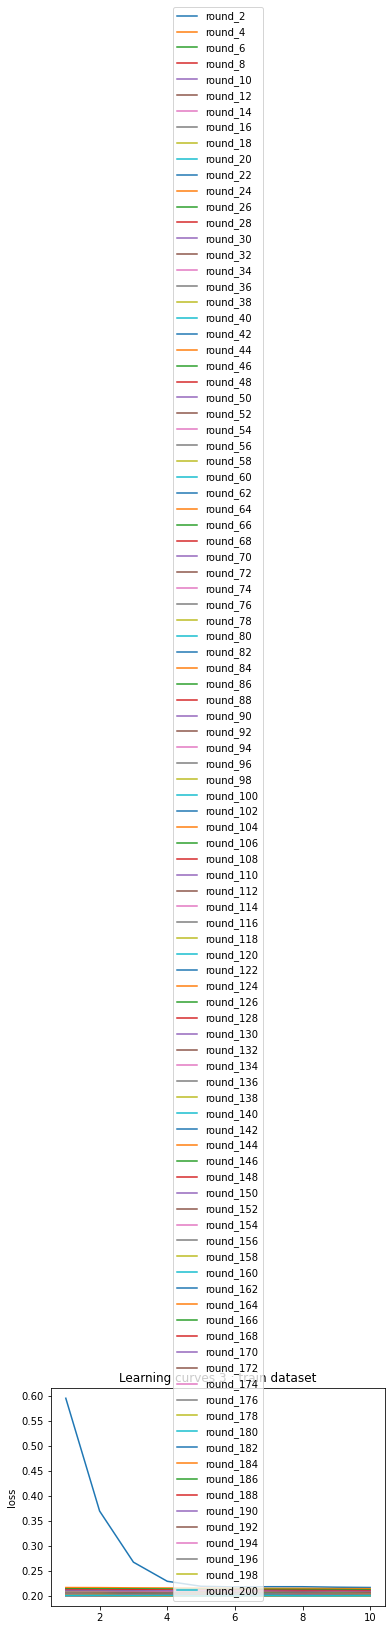

In [114]:
# for each agent plot learning curves
def plot_learning_curves(loss_stats, train_or_val):
    for ag_id in range(-1, NUM_AGENTS):
        # plot lines
        plt.figure()
        fig, ax = plt.subplots()

        ax.set_ylabel('loss')
        if ag_id == -1:    
            ax.set_title('Learning curves global_model : ' + train_or_val + ' dataset')
        else:
            ax.set_title('Learning curves ' +  str(ag_id) + ' : ' + train_or_val + ' dataset')

        if ag_id == -1:
            #x = range(1, 10 + 1)
            #y = json.loads(loss_stats[ag_id][1][train_or_val])
            #plt.plot(x, y, label = "global model" , linestyle="-")
            pass
        else:
            x = range(1, EPOCHS + 1)   
            for rnd_no in range(0, 100*2 +1):
                if rnd_no % 2 != 0: # FIXED : TO_FIX !!!!!!!!    MS: -1 added temporarly!!!! I need to find out why some clients join from 2nd round ( ask Malgorzata if that is not clear :) 
                    print('ag_id ', ag_id, 'rnd_no ', rnd_no)
                    y = json.loads(loss_stats[ag_id][rnd_no][train_or_val])
                    plt.plot(x, y, label = "round_" + str(rnd_no + 1) , linestyle="-")

        plt.legend()
        plot_name = '../plots/Learning curves agent_id ' + str(ag_id) + train_or_val + '.png'
        plt.savefig(plot_name, 
            transparent=False,  
            facecolor='white', 
            bbox_inches="tight")
        plt.close()

        pdf.image(plot_name, x = 50, y = None, w = 100, h = 0, type = 'PNG')
        pdf.cell(w=0, h=2, txt='', border=0, ln=1)

plot_learning_curves(loss_stats, "train")
pdf.cell(w=0, h=ch, txt="Model Training: Learning curves; Validation dataset", border=0, ln=1)
plot_learning_curves(loss_stats, "val")

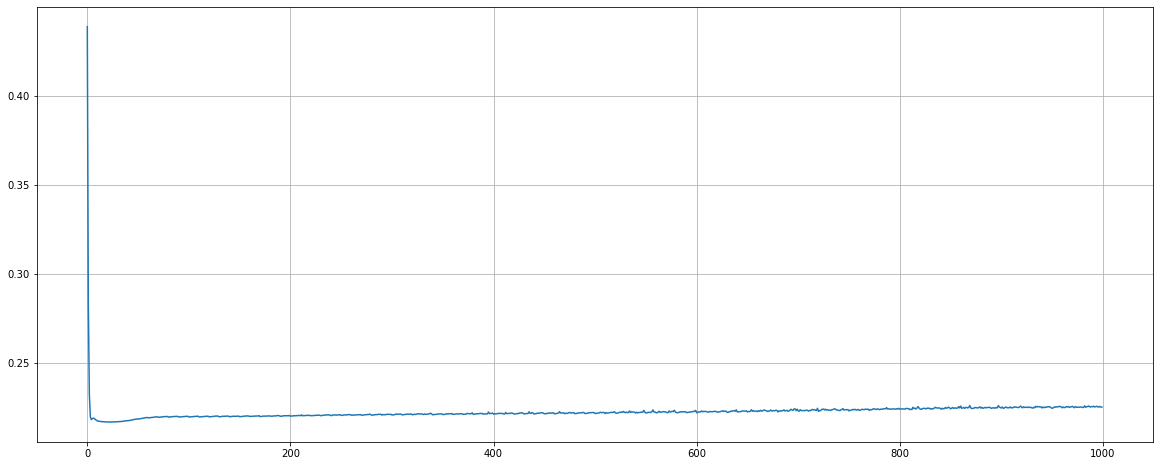

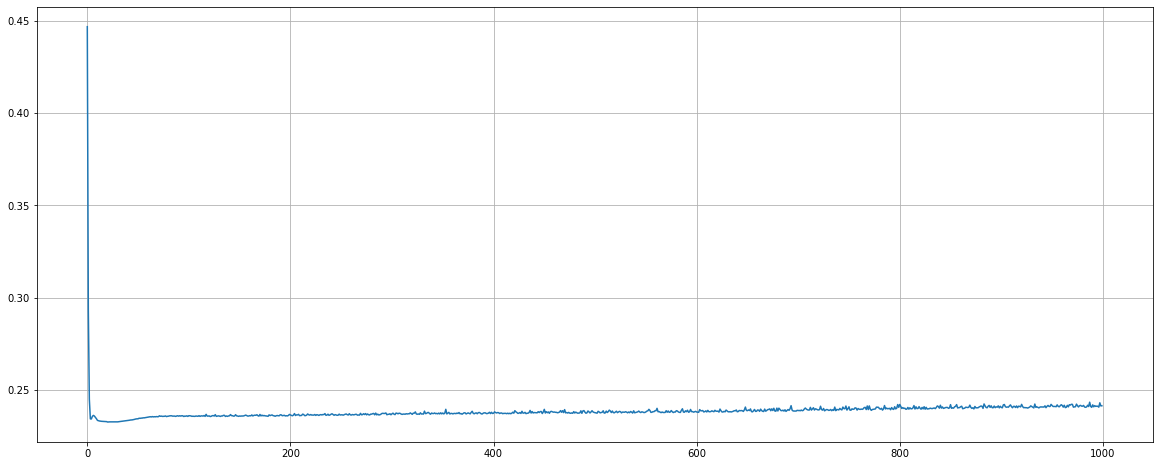

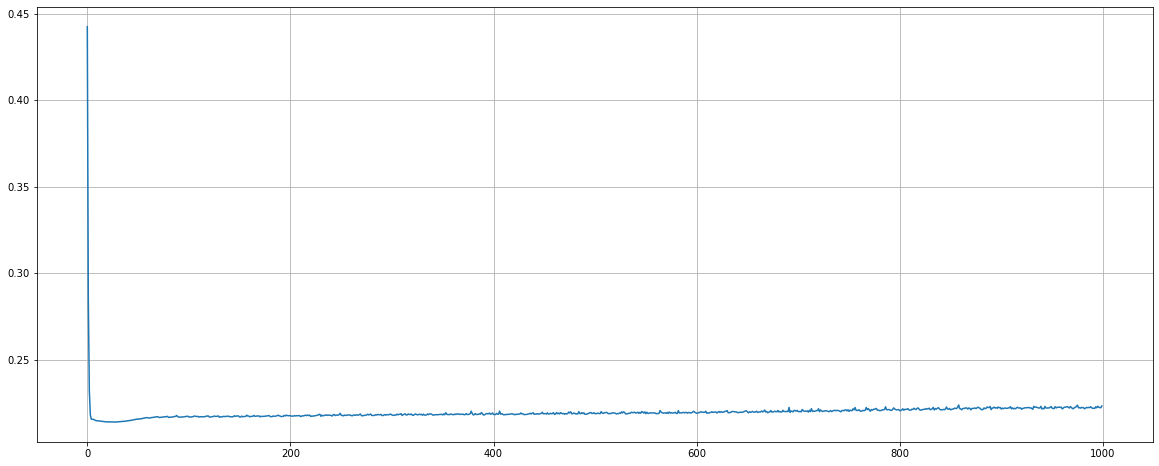

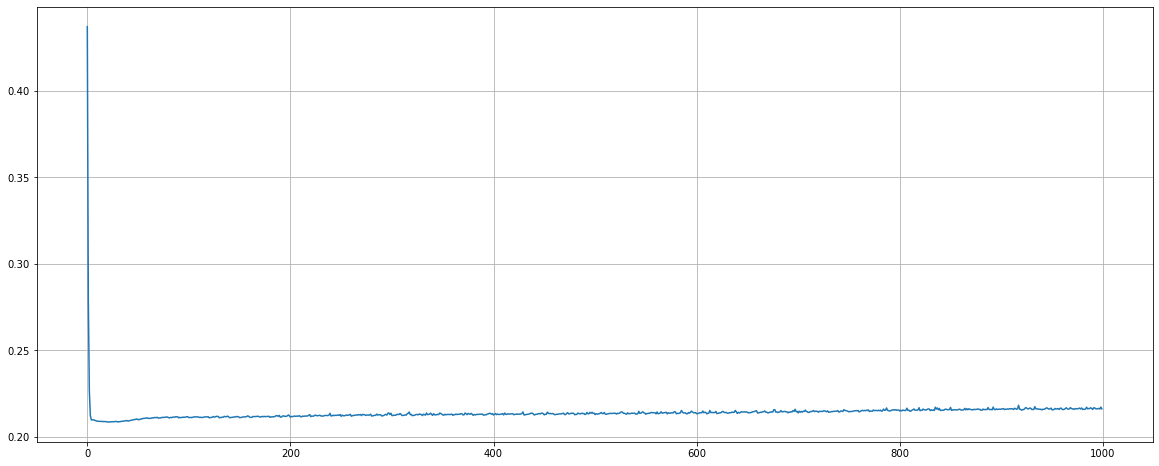

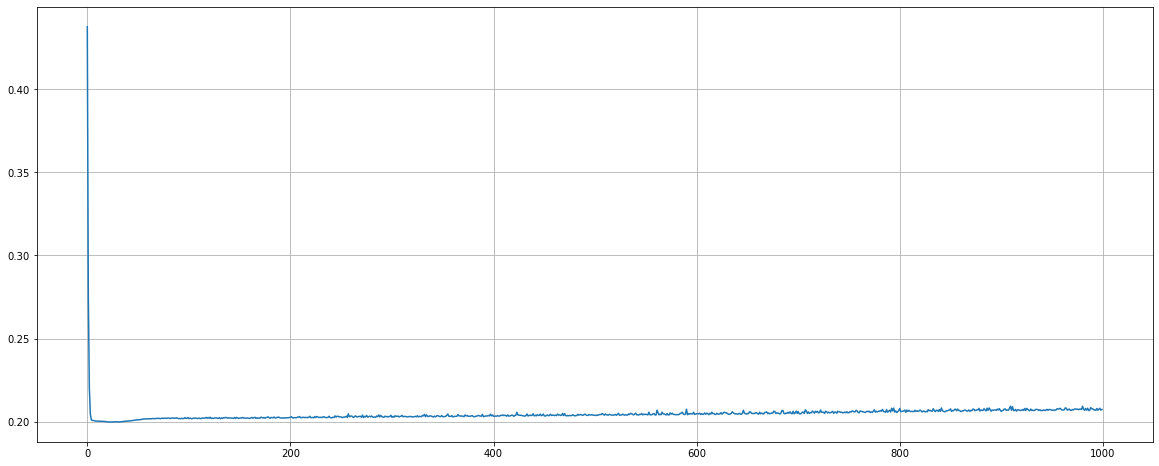

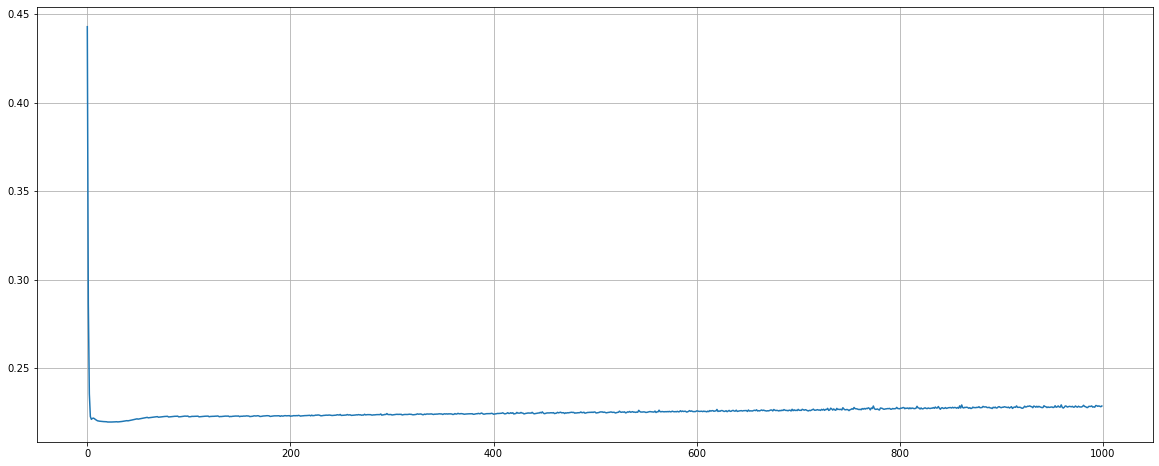

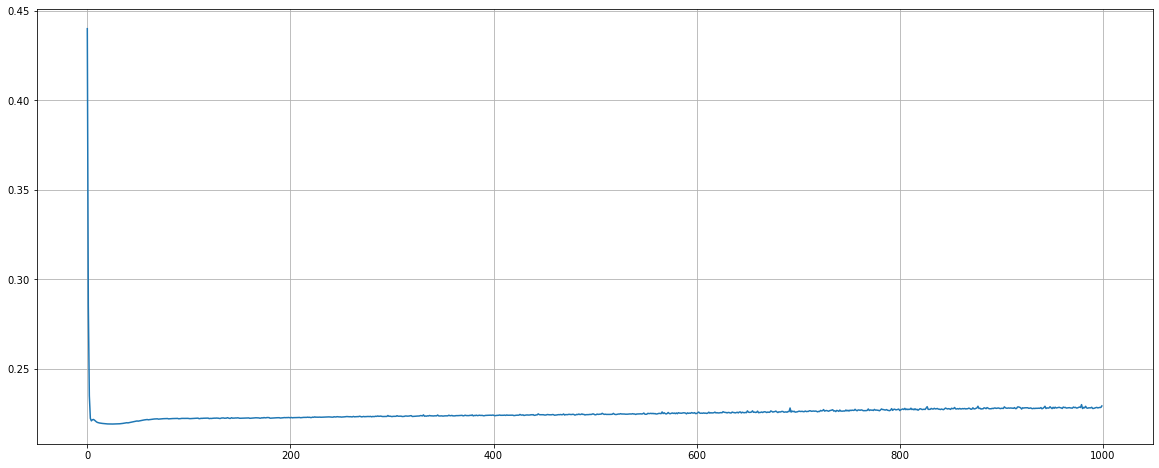

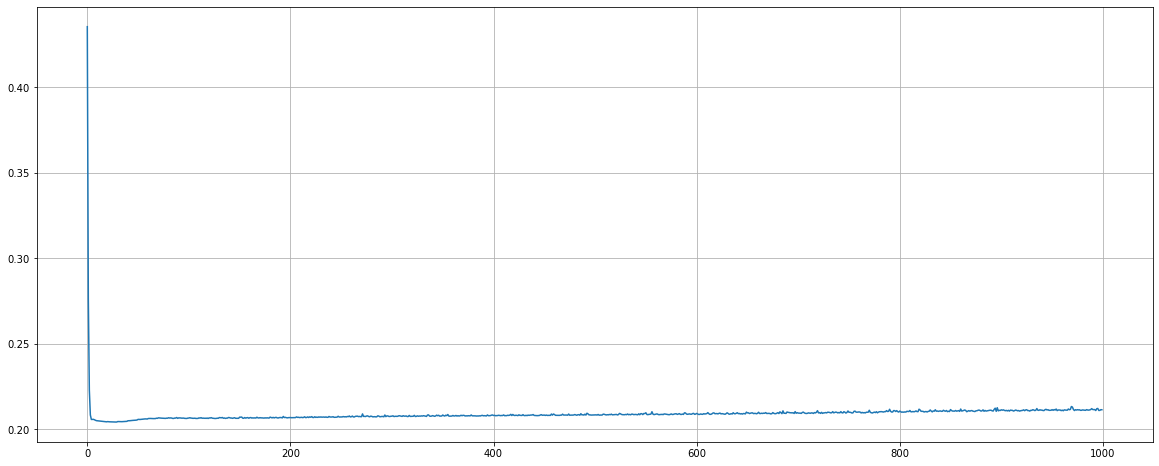

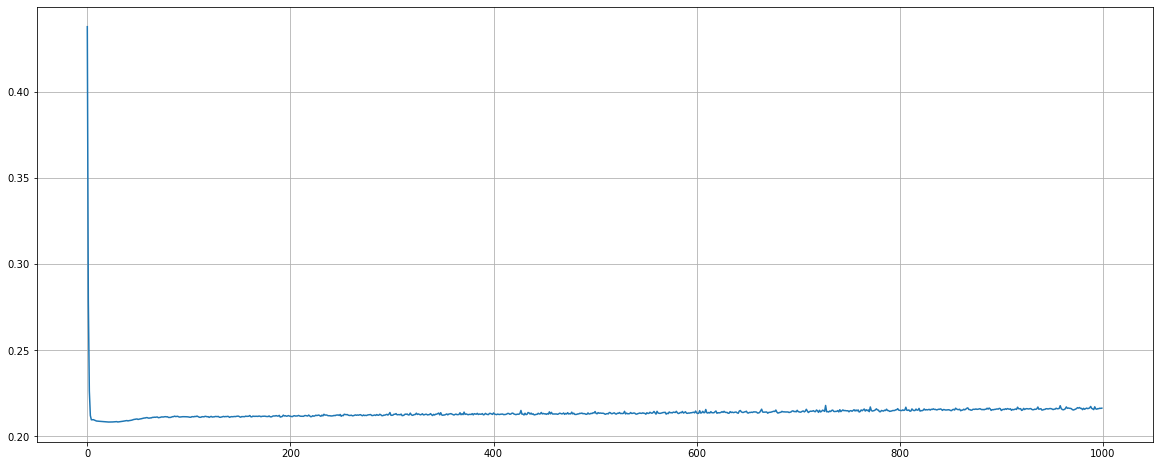

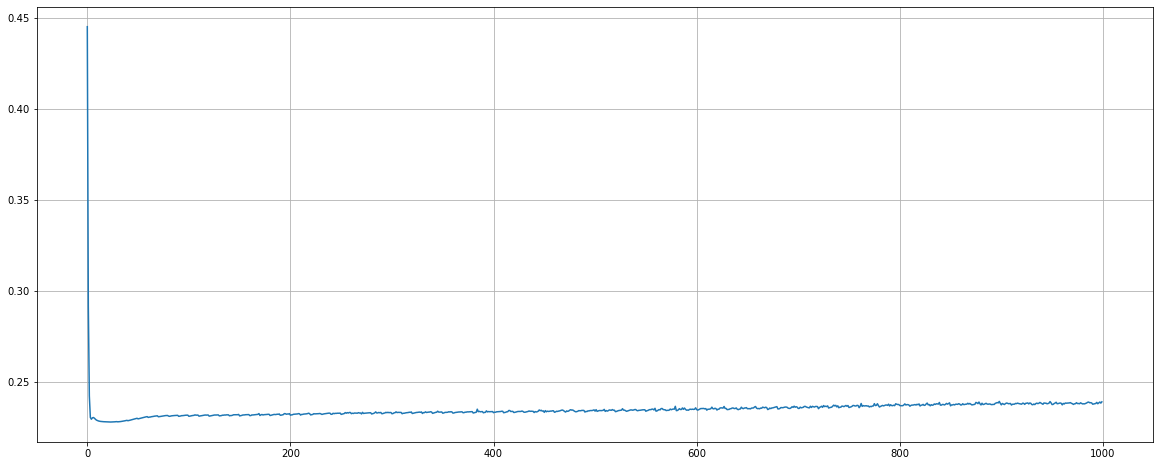

In [164]:
for ag in range(0,10):
    loss_list = []
    for rnd_no in range(0, 100*2 +1):
                    if rnd_no % 2 != 0: # FIXED : TO_FIX !!!!!!!!    MS: -1 added temporarly!!!! I need to find out why some clients join from 2nd round ( ask Malgorzata if that is not clear :) 
                        #print('ag_id ', 1, 'rnd_no ', rnd_no)
                        y = json.loads(loss_stats[ag][rnd_no]["val"])
                        loss_list.extend(y)
    plt.figure(figsize=(20,8))
    plt.plot(loss_list[0:])
    plt.grid()
    plt.show()

In [135]:
loss_list

[0.432701975107193,
 0.29435446858406067,
 0.2368980348110199,
 0.2201528549194336,
 0.21785633265972137,
 0.21842361986637115,
 0.21868370473384857,
 0.2183411717414856,
 0.21783287823200226,
 0.21743102371692657,
 0.21712417900562286,
 0.2169831097126007,
 0.21687082946300507,
 0.21677984297275543,
 0.21669581532478333,
 0.216607928276062,
 0.21654660999774933,
 0.21649247407913208,
 0.21643492579460144,
 0.21638832986354828,
 0.21633194386959076,
 0.21629701554775238,
 0.21626926958560944,
 0.2162533700466156,
 0.21622855961322784]

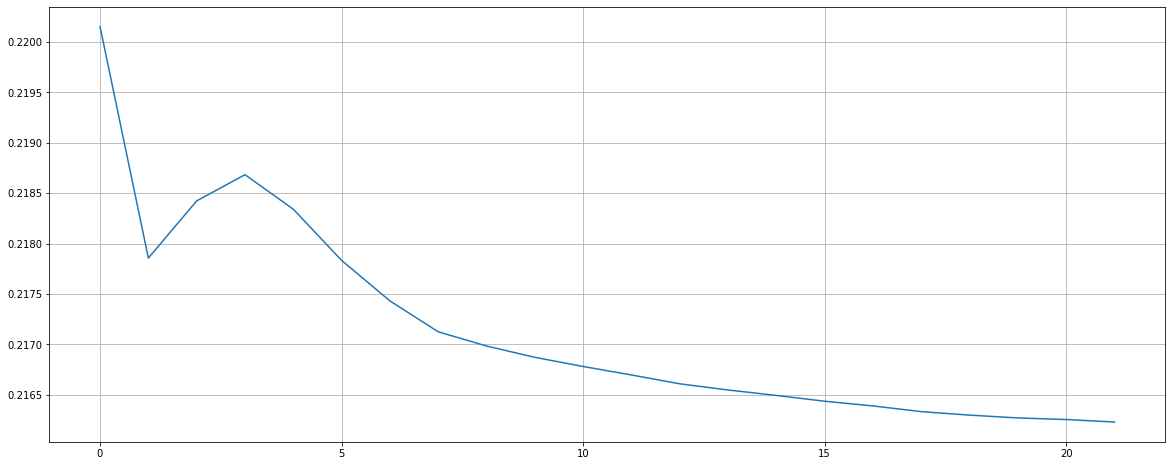

In [136]:
plt.figure(figsize=(20,8))
plt.plot(loss_list[3:])
plt.grid()
plt.show()
